In [ ]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

In [ ]:
os.chdir("./")

In [ ]:
class sentiment_analysis:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-finetuned-nsmc")
        self.model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-finetuned-nsmc")

    def __call__(self, sentence):
        inputs = self.tokenizer(
            sentence,
            return_tensors="pt",
            max_length=512,
            truncation=True
        )
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)  # 소프트맥스 적용

    # 부정(0), 긍정(1) 순서라면
    # 긍정 점수만 뽑기 (1번째 인덱스)
            positive_score = probs[0, 1].item()
        return 2 * positive_score - 1

In [ ]:
def analyze_files(file_list, sa):
    results = []
    for file in file_list:
        with open(file, "r", encoding="utf-8") as f:
            lines = f.readlines()
        for sentence in lines:
            sentence = sentence.strip()
            if not sentence:
                continue
            score = sa(sentence)
            label = "positive" if score >= 0 else "negative"
            results.append(label)
    return results

In [ ]:
if __name__ == "__main__":
    sa = sentiment_analysis()

    before_covid_files = ["2018.txt", "2019.txt"]
    covid_pandemic_files = ["2020.txt", "2021.txt", "2022.txt"]
    post_covid_files = ["2023.txt", "2024.txt"]

    categories = {
        "before covid": analyze_files(before_covid_files, sa),
        "covid pandemic": analyze_files(covid_pandemic_files, sa),
        "post covid": analyze_files(post_covid_files, sa)
    }

In [ ]:
category_names = []
positive_counts = []
negative_counts = []

for category, labels in categories.items():
    pos_count = labels.count("positive")
    neg_count = labels.count("negative")
    category_names.append(category)
    positive_counts.append(pos_count)
    negative_counts.append(neg_count)

    print(f"\n{category}:")
    print(f"  Positive: {pos_count}")
    print(f"  Negative: {neg_count}")


before covid:
  Positive: 3285
  Negative: 3343

covid pandemic:
  Positive: 4740
  Negative: 6049

post covid:
  Positive: 3231
  Negative: 3870


In [ ]:
import matplotlib.pyplot as plt

positive_ratios = []
negative_ratios = []

for pos_count, neg_count in zip(positive_counts, negative_counts):
    total = pos_count + neg_count
    positive_ratios.append(pos_count / total * 100)
    negative_ratios.append(neg_count / total * 100)

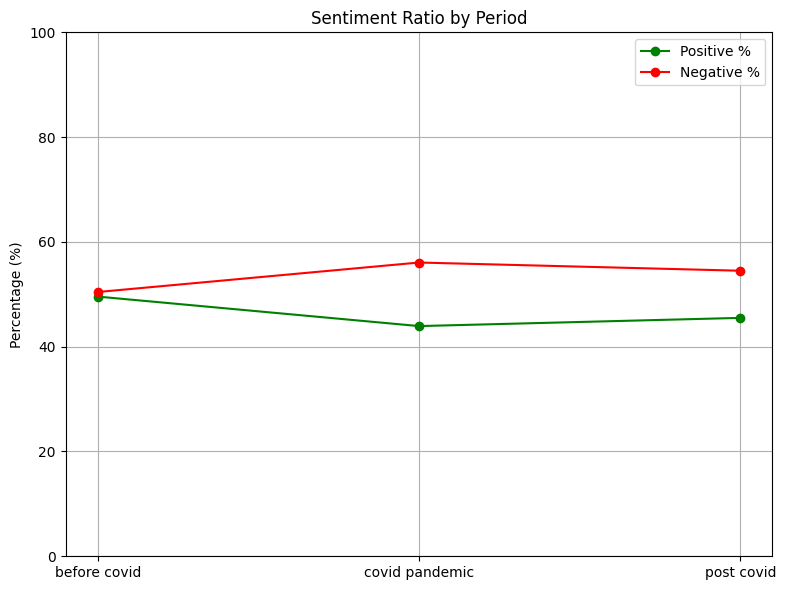

In [ ]:
plt.figure(figsize=(8, 6))
x = range(len(category_names))

plt.plot(x, positive_ratios, marker='o', color='green', label='Positive %')
plt.plot(x, negative_ratios, marker='o', color='red', label='Negative %')

plt.xticks(x, category_names)
plt.ylabel('Percentage (%)')
plt.title('Sentiment Ratio by Period')
plt.ylim(0, 100)  # 0~100% 로 고정
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()